# setup for colab notebook

In [2]:
!pwd


/content


In [3]:
import os
os.chdir('/content')
colab_path=os.getcwd()
colab_path

'/content'

In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 86.3 MB/s eta 0:00:00


In [5]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# imports

In [6]:
import pandas as pd
import numpy as np
import os
import time
import pickle
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import layers,Model,callbacks,models,optimizers
from keras import backend as K

In [7]:
#check local virtual env (expected 'plt')
!pyenv local

/bin/bash: pyenv: command not found


# Global variable

In [8]:
EMPTY_DF=pd.DataFrame()

# project path setup

In [9]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [10]:
project_path=os.path.join(colab_path,'drive','MyDrive','Colab Notebooks','plt')
os.chdir(project_path)
project_path

'/content/drive/MyDrive/Colab Notebooks/plt'

In [11]:
train_path=os.path.join(project_path,'raw_data',"train.csv")
# train_path="../raw_data/train.csv"
train_path

'/content/drive/MyDrive/Colab Notebooks/plt/raw_data/train.csv'

# load datasets

## load functions

In [12]:
def load_new_data(file_path: str, size:int =-1) -> pd.DataFrame :
    """
    'file_path' = the path to a file with a 'full_text' columln and no evaluation score (typically 'test.csv' under 'raw_data' folder)
    NB: it can be an absolute or a relative path !
    if 'size'=-1 the entire data is returned, else only the 1st 'size' rows (might also suffle if this is better) are returned
    outputs= (X_raw):
        X_raw= 2-column DataFrame ['text_id','full_text']  
        nb of rows in X_raw is controlled by the 'size' kwarg
    """
    df=pd.read_csv(file_path)
    X_raw=df[['text_id','full_text']].iloc[0:size,:]
    return X_raw

In [13]:
def load_train_test_data(file_path:str, y_index:int=-1, split_ratio:float=0.3,reshuffle:bool=True) -> (pd.DataFrame, pd.DataFrame,pd.DataFrame, pd.DataFrame) :
    """
    'file_path' = the path to the required file (typically 'train.csv' or 'test.csv' under a 'raw_data' folder)
    NB: it can be an absolute or a relative path !
    'y_index' expected values = [-1,0,1,2,3,4,5] indicated which evaluation(s) will be returned
    'split_ratio'is expected to be >0 and <1 ([0.01-0.99])
    data is reshuffled when 'reshuffle'= True!
    outputs= (X_train_raw,X_test_raw,y_train,y_test):
        X_train_raw, X_test_raw= 2x 2-column DataFrames ['text_id','full_text']  
        y_train, y_test= 2x 6-column DataFrames (or  1-column DataFrames if y_index is used)
        nb of rows in (X_train_raw,y_train,X_val_raw,y_val) is controlled by the 'split_ratio' kwarg
    """
    df=pd.read_csv(file_path)
    if reshuffle:
        df=df.sample(frac=1)
    len_train=int(df.shape[0]*(1-split_ratio))
    target_names=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
    X_train_raw=df[['text_id','full_text']].iloc[:len_train,:]
    y_train=df[target_names].iloc[:len_train,:]
    X_test_raw=df[['text_id','full_text']].iloc[len_train:,:]
    y_test=df[target_names].iloc[len_train:,:]    
    if y_index >0 and y_index < len(y_train.columns):
        y_train=y_train.iloc[:,[y_index]]         
        y_test=y_val.iloc[:,[y_index]]         
    return X_train_raw,X_test_raw,y_train,y_test

## load

In [14]:
X_raw, y= load_data(train_path)
X_raw.shape, y.shape

((3910, 2), (3910, 6))

In [14]:
X_train_raw,X_test_raw,y_train,y_test=load_train_test_data(train_path, split_ratio=0.3,reshuffle=False)
X_train_raw.shape,X_test_raw.shape,y_train.shape,y_test.shape

((2737, 2), (1174, 2), (2737, 6), (1174, 6))

## functionize data pre_processing

### punctuation preproc

In [168]:
def punctuation_preproc_(X:pd.DataFrame)->pd.DataFrame:
    """
    assumption X has a column labelled 'full_text'
    modify 'full_text': 
        *replace '\n\n' by 'CR'(=Carriage Return)
        *add spaces around dot ('.') punctation mark so that it is counted
    add a new column ('character_count')
    add a new column ('word_count')
    add a new column ('element_count')
    """
    def punctuation_processing(x:str)->str:
        x=x.replace(".", " . ")
        x=x.replace("\n\n", " CR ")
        return x
    X1=pd.DataFrame.copy(X)
    X1['character_count']=X1.full_text.apply(len)
    X1['word_count']=X1.full_text.apply(lambda x: len(x.split()))
    X1.full_text=X1.full_text.apply(punctuation_processing)
    X1['element_count']=X1.full_text.apply(lambda x: len(x.split()))
    return X1

In [169]:
def punctuation_preproc(X:pd.DataFrame,X_test:pd.DataFrame=EMPTY_DF, X_val:pd.DataFrame=EMPTY_DF)->pd.DataFrame:
    if X_test.empty and X_val.empty:
        return punctuation_preproc_(X)
    if not(X_test.empty) and X_val.empty:
        return punctuation_preproc_(X),punctuation_preproc_(X_test)
    if X_test.empty and not(X_val.empty):
        return punctuation_preproc_(X),punctuation_preproc_(X_val)
    if not(X_test.empty) and not(X_val.empty):
        return punctuation_preproc_(X),punctuation_preproc_(X_test),punctuation_preproc_(X_val)
    return None

### sentence preproc

In [170]:
def sentence_preproc_(X:pd.DataFrame)->pd.DataFrame:
    """
    assumption X has a column labelled 'full_text'
    shorten 'full_text' with following rules:
        * it ends with a dot ('.')
        * as long as possible but less than 490 elements (~words)    
    add a new column ('new_element_count')
    """
    def sentence_processing(x:str)->str:
        tokens=x.split()
        if len(tokens)>490:
            tokens=tokens[:490]
        x=' '.join(tokens)
        x.rstrip('.')
        return x
    X1=pd.DataFrame.copy(X)
    X1.full_text=X1.full_text.apply(sentence_processing)
    X1['new_element_count']=X1.full_text.apply(lambda x: len(x.split()))
    return X1

In [171]:
def sentence_preproc(X:pd.DataFrame,X_test:pd.DataFrame=EMPTY_DF, X_val:pd.DataFrame=EMPTY_DF)->pd.DataFrame:
    if X_test.empty and X_val.empty:
        return sentence_preproc_(X)
    if not(X_test.empty) and X_val.empty:
        return sentence_preproc_(X),sentence_preproc_(X_test)
    if X_test.empty and not(X_val.empty):
        return sentence_preproc_(X),sentence_preproc_(X_val)
    if not(X_test.empty) and not(X_val.empty):
        return sentence_preproc_(X),sentence_preproc_(X_test),sentence_preproc_(X_val)
    return None

### tokenize preproc

In [15]:
def token_preproc(X:pd.DataFrame,X_test:pd.DataFrame=EMPTY_DF, X_val:pd.DataFrame=EMPTY_DF)->pd.DataFrame:

    def token_preproc_(X):
      tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
      return tokenizer(list(X.full_text), padding='max_length',truncation=True,return_tensors="tf",return_token_type_ids=False)
    
    if X_test.empty and X_val.empty:
        return token_preproc_(X)
    if not(X_test.empty) and X_val.empty:
        return token_preproc_(X), token_preproc_(X_test)
    if X_test.empty and not(X_val.empty):
        return token_preproc_(X), token_preproc_(X_val)
    if not(X_test.empty) and not(X_val.empty):
        return token_preproc_(X), token_preproc_(X_test), token_preproc_(X_val)
    return None

# BERT Basic Model

## Built model

###  Definy initate_bert_model() function

In [17]:
def initiate_bert_model():
    bert = TFBertModel.from_pretrained('bert-base-cased')
    bert.trainable=False
    
    token_ids_layer =layers.Input(shape=(512,),dtype=np.int32,name='input_ids')
    attention_mask_layer = layers.Input(shape=(512,),dtype=np.int32,name='attention_mask')
    input_layer=dict(input_ids=token_ids_layer,attention_mask=attention_mask_layer)
    
    pooler_output_layer= bert(input_layer)[1]
    
    dense1_layer = layers.Dense(128,activation='relu')(pooler_output_layer)
    
    #parallel layers : 1 layer for each output (score)
    cohesion_output=layers.Dense(1, activation="linear", name="cohesion")(dense1_layer)
    syntax_output=layers.Dense(1, activation="linear", name="syntax")(dense1_layer)
    vocabulary_output=layers.Dense(1, activation="linear", name="vocabulary")(dense1_layer)
    phraseology_output=layers.Dense(1, activation="linear", name="phraseology")(dense1_layer)
    grammar_output=layers.Dense(1, activation="linear", name="grammar")(dense1_layer)
    conventions_output=layers.Dense(1, activation="linear", name="conventions")(dense1_layer)
    
    # Assembling the model
    model = Model(inputs=input_layer, 
            outputs=[cohesion_output, syntax_output, vocabulary_output, phraseology_output, grammar_output, conventions_output])
    return model

###  Instanciate Model (with initate_bert_model() function !)

In [22]:
model=initiate_bert_model()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

### Compile model

In [20]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [127]:
opt=optimizers.Adam(learning_rate=0.001)


In [128]:
model.compile(loss='mse', optimizer=opt, loss_weights=[1/6 for i in range(6)], metrics=root_mean_squared_error)

## Train model

### preprocess data

chose **only one** of the 3 options below (run the full sub-section)

#### full preproc

In [26]:
X_train_preproc,X_test_preproc=punctuation_preproc(X_train_raw, X_test=X_test_raw)
X_train_preproc.shape,X_test_preproc.shape

((2737, 5), (1174, 5))

In [27]:
X_train_preproc,X_test_preproc=sentence_preproc(X_train_preproc,X_test=X_test_preproc)
X_train_preproc.shape,X_test_preproc.shape

((2737, 6), (1174, 6))

In [28]:
X_train_tokenized,X_test_tokenized=token_preproc(X_train_preproc,X_test=X_test_preproc)
X_train_tokenized['input_ids'].shape, X_test_tokenized['input_ids'].shape,y_train.shape,y_test.shape

(TensorShape([2737, 512]), TensorShape([1174, 512]), (2737, 6), (1174, 6))

#### only punctation preproc

In [120]:
X_train_preproc,X_test_preproc=punctuation_preproc(X_train_raw, X_test=X_test_raw)
X_train_preproc.shape,X_test_preproc.shape

((2737, 5), (1174, 5))

In [121]:
X_train_tokenized,X_test_tokenized=token_preproc(X_train_preproc,X_test=X_test_preproc)
X_train_tokenized['input_ids'].shape, X_test_tokenized['input_ids'].shape,y_train.shape,y_test.shape

(TensorShape([2737, 512]), TensorShape([1174, 512]), (2737, 6), (1174, 6))

#### no preprocess

In [18]:
X_train_tokenized,X_test_tokenized=token_preproc(X_train_raw,X_test=X_test_raw)
X_train_tokenized['input_ids'].shape, X_test_tokenized['input_ids'].shape,y_train.shape,y_test.shape

(TensorShape([2737, 512]), TensorShape([1174, 512]), (2737, 6), (1174, 6))

### train model

In [129]:
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [130]:
history=model.fit(X_train_tokenized.data,
          y_train,
          validation_split=0.2,
          batch_size=64,
          epochs=100,
          verbose=1,
          callbacks=[es])

Epoch 1/100
35/35 [==============================] - 141s 4s/step - loss: 0.3271 - cohesion_loss: 0.3266 - syntax_loss: 0.3272 - vocabulary_loss: 0.3261 - phraseology_loss: 0.3281 - grammar_loss: 0.3265 - conventions_loss: 0.3280 - cohesion_root_mean_squared_error: 0.5261 - syntax_root_mean_squared_error: 0.5267 - vocabulary_root_mean_squared_error: 0.5258 - phraseology_root_mean_squared_error: 0.5274 - grammar_root_mean_squared_error: 0.5261 - conventions_root_mean_squared_error: 0.5275 - val_loss: 0.3249 - val_cohesion_loss: 0.3247 - val_syntax_loss: 0.3252 - val_vocabulary_loss: 0.3234 - val_phraseology_loss: 0.3263 - val_grammar_loss: 0.3242 - val_conventions_loss: 0.3260 - val_cohesion_root_mean_squared_error: 0.5252 - val_syntax_root_mean_squared_error: 0.5255 - val_vocabulary_root_mean_squared_error: 0.5239 - val_phraseology_root_mean_squared_error: 0.5260 - val_grammar_root_mean_squared_error: 0.5247 - val_conventions_root_mean_squared_error: 0.5260
Epoch 2/100
35/35 [=========

### enrich history

In [107]:
def enrich_history(history):
  """
  compute 'MCRSME' and 'val_MCRSME' 
  and add them as 2 new keys in 'history.history' dictionary
  """
  if 'MCRMSE' in history.history.keys(): #ensure history is enriched only once !
    return history
  metrics=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
  history.history['MCRMSE']=[]
  history.history['val_MCRMSE']=[]
  for epoch in range(len(history.history['loss'])):
    mcrmse=0
    val_mcrmse=0
    for m in metrics:
      mcrmse +=history.history[f'{m}_root_mean_squared_error'][epoch]
      val_mcrmse +=history.history[f'val_{m}_root_mean_squared_error'][epoch]
    history.history['MCRMSE'].append(mcrmse/len(metrics))
    history.history['val_MCRMSE'].append(val_mcrmse/len(metrics))
  return history

In [108]:
history=enrich_history(history)

In [109]:
history.history.keys()

dict_keys(['loss', 'cohesion_loss', 'syntax_loss', 'vocabulary_loss', 'phraseology_loss', 'grammar_loss', 'conventions_loss', 'cohesion_root_mean_squared_error', 'syntax_root_mean_squared_error', 'vocabulary_root_mean_squared_error', 'phraseology_root_mean_squared_error', 'grammar_root_mean_squared_error', 'conventions_root_mean_squared_error', 'val_loss', 'val_cohesion_loss', 'val_syntax_loss', 'val_vocabulary_loss', 'val_phraseology_loss', 'val_grammar_loss', 'val_conventions_loss', 'val_cohesion_root_mean_squared_error', 'val_syntax_root_mean_squared_error', 'val_vocabulary_root_mean_squared_error', 'val_phraseology_root_mean_squared_error', 'val_grammar_root_mean_squared_error', 'val_conventions_root_mean_squared_error', 'MCRMSE', 'val_MCRMSE'])

### plot learning curves

In [95]:
def plot_history(history, title='', axs=None, exp_name=""):
  """
  'history' shall be the 'augmented history' !
  """
  enrich_history(history)
  metrics=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
  scores=['loss','root_mean_squared_error']
  if axs is not None:
      ax1, ax2 = axs
  else:
      f, ax = plt.subplots(7, 2, figsize=(12, 2*7))
  
  if len(exp_name) > 0 and exp_name[0] != '_':
      exp_name = '_' + exp_name

  ax[0][0].plot(history.history['loss'], label='train' + exp_name)
  ax[0][0].plot(history.history['val_loss'], label='val' + exp_name)
  ax[0][0].set_title('loss')
  ax[0][0].legend()
  
  ax[0][1].plot(history.history['MCRMSE'], label='train' + exp_name)
  ax[0][1].plot(history.history['val_MCRMSE'], label='val' + exp_name)
  ax[0][1].set_title('MCRMSE')
  ax[0][1].legend()
  i=0
  for m in metrics:
    j=0
    i+=1
    for s in scores:
      ax[i][j].plot(history.history[f'{m}_{s}'], label='train' + exp_name)
      ax[i][j].plot(history.history[f'val_{m}_{s}'], label='val' + exp_name)
      ax[i][j].set_title(f'{m}_{s}')
      ax[i][j].legend()
      j+=1
      
  return ax

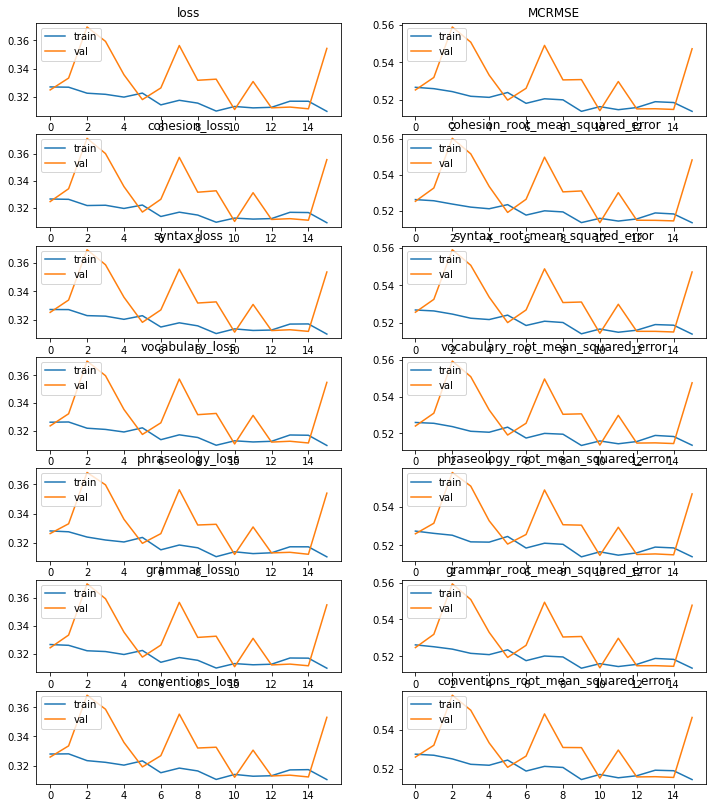

In [131]:
plot_history(history);

In [132]:
min(history.history['val_loss']), min(history.history['val_MCRMSE'])

(0.3110530376434326, 0.5141095618406931)

## Save model, weights and history

In [133]:
experiment_name='bert_punc_preproc_LR_0_001'

In [134]:
#get a timestamp
timestamp = time.strftime("%Y%m%d-%H%M%S")

In [135]:
# save model locally
model_path = os.path.join(project_path,"models", f"{timestamp}.{experiment_name}.model.h5")
model.save(model_path)
# save weights locally
weights_path = os.path.join(project_path,"weights", f"{timestamp}.{experiment_name}.weights.h5")
model.save_weights(weights_path)
# save history locally
hist_df = pd.DataFrame(history.history)
history_path = os.path.join(project_path, "history", f"{timestamp}.{experiment_name}.history.csv")
hist_df.to_csv(history_path)

## Load latest Model, Weights and History

### Load Model

In [102]:
model_files=os.listdir(os.path.join(project_path,'models'))
model_files

['20230309-070734.h5', '20230309-071043.bert.h5']

In [101]:
most_recent_model_on_disk = sorted(model_files)[-1]
most_recent_model_on_disk


'20230309-071043.bert.h5'

In [104]:
os.path.join(project_path,'models',most_recent_model_on_disk)

'/content/drive/MyDrive/Colab Notebooks/plt/models/20230309-071043.bert.h5'

In [ ]:
model=models.load_model(os.path.join(project_path,'models',most_recent_model_on_disk),
                        custom_objects={"TFBertModel": TFBertModel})

### build Model and load Weights

In [21]:
model=initiate_bert_model()
model.compile(loss='mse', optimizer='adam', loss_weights=[1/6 for i in range(6)], metrics=root_mean_squared_error)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [22]:
weights_files=os.listdir(os.path.join(project_path,'weights'))
weights_files

['20230310-090249.bert.weights.h5',
 '20230310-114546.bert.weights.h5',
 '20230310-121739.bert.weights.h5',
 '20230310-123716.bert.weights.h5',
 '20230310-124246.bert_full_preproc_LR_0_001.weights.h5',
 '20230310-132700.bert_no_preproc_LR_0_001.weights.h5',
 '20230310-143451.bert_punc_preproc_LR_0_001.weights.h5']

In [23]:
most_recent_weights_on_disk = sorted(weights_files)[-2] #play with this in dex to select the one you want
most_recent_weights_on_disk


'20230310-132700.bert_no_preproc_LR_0_001.weights.h5'

In [24]:
os.path.join(project_path,'weights',most_recent_weights_on_disk)

'/content/drive/MyDrive/Colab Notebooks/plt/weights/20230310-132700.bert_no_preproc_LR_0_001.weights.h5'

In [25]:
model.load_weights(os.path.join(project_path,'weights',most_recent_weights_on_disk))

### load history

In [63]:
history_files=os.listdir(os.path.join(project_path,'history'))
history_files

['20230309-071043.history.pickle',
 '20230310-090249.history.pickle',
 '20230310-114546.history.csv']

In [64]:
most_recent_history_on_disk = sorted(history_files)[-1]
most_recent_history_on_disk


'20230310-114546.history.csv'

In [65]:
os.path.join(project_path,'history',most_recent_history_on_disk)

'/content/drive/MyDrive/Colab Notebooks/plt/history/20230310-114546.history.csv'

In [66]:
history_df=pd.read_csv(os.path.join(project_path,'history',most_recent_history_on_disk))

In [67]:
history_df

,Unnamed: 0,loss,cohesion_loss,syntax_loss,vocabulary_loss,phraseology_loss,grammar_loss,conventions_loss,cohesion_root_mean_squared_error,syntax_root_mean_squared_error,...,val_grammar_loss,val_conventions_loss,val_cohesion_root_mean_squared_error,val_syntax_root_mean_squared_error,val_vocabulary_root_mean_squared_error,val_phraseology_root_mean_squared_error,val_grammar_root_mean_squared_error,val_conventions_root_mean_squared_error,MCRMSE,val_MCRMSE
0,0,1.391277,1.000777,1.541241,1.517452,1.836934,1.419737,1.031524,0.839457,0.982094,...,0.447254,0.459845,0.671438,0.630439,0.635086,0.652160,0.608093,0.615347,0.925322,0.635427
1,1,0.430734,0.429942,0.417614,0.463816,0.463095,0.403495,0.406441,0.596720,0.588683,...,0.404468,0.398304,0.598528,0.590155,0.611618,0.615679,0.581977,0.577490,0.596340,0.595908
2,2,0.395108,0.387007,0.390498,0.422903,0.424922,0.377945,0.367375,0.569937,0.571346,...,0.380720,0.372980,0.580623,0.573808,0.590699,0.600099,0.566119,0.559577,0.574605,0.578488
3,3,0.376738,0.373537,0.369650,0.391625,0.404425,0.365192,0.355999,0.560825,0.558500,...,0.363220,0.352230,0.561627,0.554841,0.574524,0.584343,0.554603,0.546716,0.562961,0.562776
4,4,0.361517,0.354918,0.351954,0.378281,0.381316,0.357534,0.345101,0.548234,0.545498,...,0.349576,0.342334,0.545265,0.543323,0.560791,0.563557,0.544974,0.540514,0.551566,0.549737
5,5,0.343858,0.337836,0.333728,0.360803,0.362761,0.340053,0.327970,0.535779,0.533675,...,0.357638,0.365113,0.551185,0.552277,0.549347,0.554808,0.552094,0.558388,0.540159,0.553017
6,6,0.336681,0.329645,0.328627,0.350915,0.354075,0.334333,0.322491,0.530589,0.529194,...,0.329162,0.343354,0.536825,0.543670,0.540611,0.543802,0.529762,0.542686,0.534617,0.539559
7,7,0.329703,0.327237,0.325081,0.336993,0.338070,0.327517,0.323321,0.528637,0.526636,...,0.334333,0.329729,0.532220,0.539060,0.537303,0.543193,0.535664,0.532544,0.530074,0.536664
8,8,0.324356,0.323216,0.318125,0.331920,0.335208,0.320909,0.316759,0.524427,0.520994,...,0.344488,0.314882,0.527669,0.526556,0.545458,0.551281,0.543867,0.519928,0.525505,0.535793
9,9,0.320208,0.314432,0.312788,0.328916,0.332596,0.322053,0.310465,0.518223,0.516831,...,0.328280,0.338572,0.547996,0.523511,0.525901,0.532764,0.530618,0.538936,0.522186,0.533288


## Evaluate Model

In [26]:
res=model.evaluate(X_test_tokenized.data,y_test)
np.mean(res[-6:])

KeyboardInterrupt: ignored

## Predict using trained Model

###  load texts samples from test.csv

In [50]:
test_path=os.path.join(project_path,'raw_data',"test.csv")
# train_path="../raw_data/train.csv"
test_path

'/content/drive/MyDrive/Colab Notebooks/plt/raw_data/test.csv'

In [51]:
df=pd.read_csv(test_path)
df

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


###  make new DF from 3 texts (str)

In [52]:
new_str0=df.iat[0,1]
new_str1=df.iat[1,1]
new_str2=df.iat[2,1]

In [53]:
# Make it a data_frame with 'full_text'
X_new=pd.DataFrame({'full_text': pd.Series([new_str0,new_str1,new_str2])})
X_new

,full_text
0,when a person has no experience on a job their...
1,Do you think students would benefit from being...
2,"Thomas Jefferson once states that ""it is wonde..."


###  tokenize and score this new texts (in a df)

In [55]:
X_new_tokenized=token_preproc(X_new)
X_new_tokenized['input_ids'].shape

TensorShape([3, 512])

In [56]:
scores= model.predict(X_new_tokenized.data)


1/1 [==============================] - 9s 9s/step


In [58]:
metrics=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
score_dict={}
i=0
for m in metrics:
  score_dict[m]=[]
  for j in range(len(scores[0])):
    score_dict[m].append(scores[i][j][0])
  i+=1
score_dict
score_df=pd.DataFrame(score_dict)
score_df

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,2.852294,2.834302,2.926423,2.931327,2.859325,2.790612
1,2.622171,2.561584,2.628937,2.574733,2.615530,2.507566
2,3.216676,3.194053,3.251763,3.257598,3.226331,3.160843


###  make a sample with one text only, score this new texts (in a df)

In [59]:
# Make it a data_frame with 'full_text'
X_new=pd.DataFrame({'full_text': pd.Series([new_str0])})
X_new

,full_text
0,when a person has no experience on a job their...


In [60]:
X_new_tokenized=token_preproc(X_new)
X_new_tokenized['input_ids'].shape

TensorShape([1, 512])

In [61]:
scores= model.predict(X_new_tokenized.data)


1/1 [==============================] - 2s 2s/step


In [62]:
metrics=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
score_dict={}
i=0
for m in metrics:
  score_dict[m]=[]
  for j in range(len(scores[0])):
    score_dict[m].append(scores[i][j][0])
  i+=1
score_dict
score_df=pd.DataFrame(score_dict)
score_df

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,2.852294,2.834302,2.926423,2.931327,2.859325,2.790612


###  functionize "score a new text"

In [63]:
def score_to_dict(score):
  metrics=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
  score_dict={}
  i=0
  for m in metrics:
    score_dict[m]=[]
    for j in range(len(score[0])):
      score_dict[m].append(score[i][j][0])
    i+=1
  return score_dict

In [71]:
def score_new_text(model:model,text:str)->pd.DataFrame:
  X_new=pd.DataFrame({'full_text': pd.Series([text])})
  X_new_tokenized=token_preproc(X_new)
  score= model.predict(X_new_tokenized.data)
  return pd.DataFrame(score_to_dict(score))

In [72]:
score_new_text(model,new_str0)

1/1 [==============================] - 4s 4s/step


,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,2.852294,2.834302,2.926423,2.931327,2.859325,2.790612
